In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import scipy.optimize
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
EARTH_RADIUS = 6371.0 # km - equitorial
NP = (90,0)
weight_limit = 1000
sleigh_weight = 10

In [3]:
def haversine(loc1, loc2):
    """Haversine"""
    dlon = np.radians(loc2[1]-loc1[1])
    dlat = np.radians(loc2[0]-loc1[0])
    dr = np.sin(dlat/2.0)**2
    dr += np.cos(np.radians(loc1[0]))*np.cos(np.radians(loc2[0]))*np.sin(dlon/2.0)**2
    #dr = 2*np.arctan2(np.sqrt(dr),np.sqrt(1-dr))
    dr = 2*np.arcsin(np.sqrt(dr))
    dr = EARTH_RADIUS*dr
    return dr

In [4]:
def WTL(stops, weights):
    """ Weighted Trip Length"""
    tuples = [tuple(x) for x in stops.values]
    # adding the last trip back to north pole, with just the sleigh weight
    tuples.append(NP)
    weights.append(sleigh_weight)
    
    dist = 0.0
    prev_stop = NP
    prev_weight = sum(weights)
    for location, weight in zip(tuples, weights):
        dist = dist + haversine(location, prev_stop) * prev_weight
        prev_stop = location
        prev_weight = prev_weight - weight
    return dist

In [5]:
def WRW(all_trips):
    """ Weighted Reindeer Weariness"""
    uniq_trips = all_trips.TripId.unique()
    #print(all_trips.groupby('TripId').Weight.sum())
    if any(all_trips.groupby('TripId').Weight.sum() > weight_limit):
        raise Exception("One of the sleighs over weight limit!")
 
    dist = 0.0
    for t in uniq_trips:
        this_trip = all_trips[all_trips.TripId==t]
        dist = dist + WTL(this_trip[['Latitude','Longitude']], this_trip.Weight.tolist())
    
    return dist    

In [6]:
gifts = pd.read_csv('gifts.csv')
sample_sub = pd.read_csv('sample_submission.csv')

all_trips = sample_sub.merge(gifts, on='GiftId')
bench_WRW = WRW(all_trips)
print(bench_WRW)
samp = gifts.sample(5000)
#samp = gifts

144525525772.0


In [7]:
def pt_map(pts, **kwargs):
    m = Basemap(projection='merc',llcrnrlat=-80,urcrnrlat=80,\
                llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')
    m.drawcoastlines()
    m.fillcontinents(color='coral',lake_color='aqua')
    # draw parallels and meridians.
    m.drawparallels(np.arange(-90.,91.,30.))
    m.drawmeridians(np.arange(-180.,181.,60.))
    m.drawmapboundary(fill_color='cyan')
    xx, yy = m(pts.Longitude.tolist(), pts.Latitude.tolist())
    plt.gca().scatter(xx, yy, pts.Weight*2, zorder=10, alpha=0.1, **kwargs)
    return m

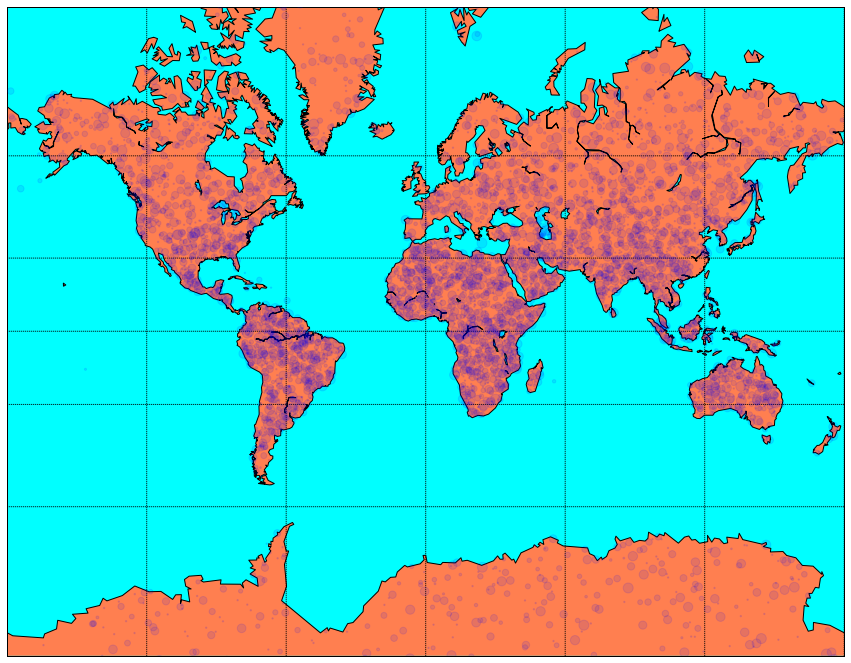

In [8]:
f = plt.figure(figsize=(15,15))
pt_map( samp, color='b' )
plt.show()

In [9]:

clust_model = KMeans(init='random', n_clusters=25, n_init=10, max_iter=300, n_jobs=4)
%time clust_model.fit(samp.as_matrix(columns=reversed(samp.columns[1:3])))

CPU times: user 50 ms, sys: 16.7 ms, total: 66.7 ms
Wall time: 364 ms


KMeans(copy_x=True, init='random', max_iter=300, n_clusters=25, n_init=10,
    n_jobs=4, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

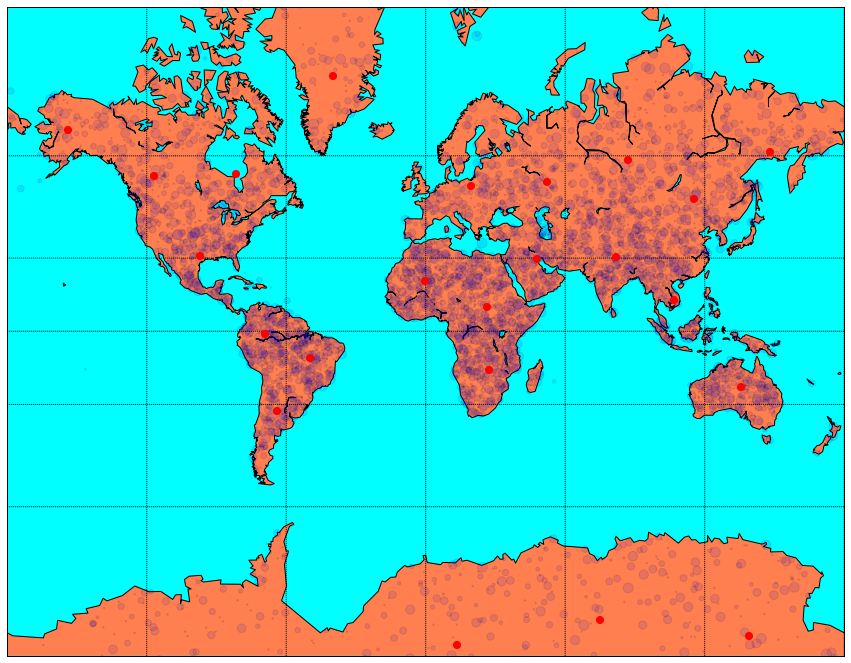

In [10]:
f = plt.figure(figsize=(15,15))
centroids = clust_model.cluster_centers_
m = pt_map(samp)
xx, yy = m(centroids[:,0], centroids[:,1])
plt.scatter(xx, yy,marker='o', color='r', s=50, zorder=100)
plt.show()

In [11]:
def kmeans_divide( group, m, tot_trip, c_trip, lvl=1 ):
    """ Subdivides a cluster into smaller clusters until the total weight is under the max weight limit """
    clust_model = KMeans(init='random', n_clusters=3, n_init=10, max_iter=1000)
    clust_model.fit(group.as_matrix(columns=reversed(group.columns[1:3])))
    
    centroids = clust_model.cluster_centers_
    xx, yy = m(centroids[:,0], centroids[:,1])
    plt.scatter(xx, yy, color='r', s=50-lvl*7, zorder=100-lvl, alpha=1.0-lvl*0.1)
    
    group['ClusterGroup{}'.format(lvl)] = pd.Series(clust_model.labels_, index=group.index)
    grouped = group.groupby('ClusterGroup{}'.format(lvl))
    for name, g in grouped:
        print('\rLevel: {},  Group: {}'.format(lvl, name), end='')
        if name != 0: continue
        w = g.Weight.sum()
        if w > weight_limit - sleigh_weight:
            tot_trip = kmeans_divide(g, m, tot_trip, c_trip, lvl+1)
        else:
            path = anneal(g)
            tot_trip = tot_trip.append( pd.DataFrame({'GiftId': path.GiftId, 'TripId' : tot_trip.TripId.max()+1}) )
            xx, yy = m(path['Longitude'].tolist(), path['Latitude'].tolist())
            plt.plot(xx, yy, linewidth=1.5,color='r')
            
    return tot_trip

In [25]:
def anneal( group, trials=1000 ):
    best = WTL(group[['Latitude','Longitude']], group.Weight.tolist())
    
    for i in range(trials):
        ind = group.index.values
        swp = np.random.choice(len(ind),2)
        swp = [1,2]
        s = ind[swp[0]]
        ind[swp[0]], ind[swp[1]] = ind[swp[1]], ind[swp[0]]
        print(swp)
        print(group)
        n_group = group.reindex(ind)
        print(n_group)
        new = WTL(n_group[['Latitude','Longitude']], n_group.Weight.tolist())
        print('Ratio of new to best',new/best)
       
        print(swp)
        print(group)
        print(n_group)
        if new < best:
            group = n_group
            best = new
    
    return group
    """
    random shuffle
    solutions = [group]
    scores = [WTL(group[['Latitude','Longitude']], group.Weight.tolist())]
    #print('Annealing for initial cost:', WTL(group[['Latitude','Longitude']], group.Weight.tolist()))
    for i in range(trials):
        solution.append(group.iloc[np.random.permutation(len(group))])
        scores.append(WTL(solutions[-1][['Latitude','Longitude']], solutions[-1].Weight.tolist()))
    # The solution with the minimum distance   
    best = solutions[np.argsort(scores)[0]]
    #print('finnished annealing, final cost:', sorted(scores)[0],'(',sorted(scores)[0]/scores[0]*100,'%)')
    """
    return group

Level: 4,  Group: 0[1, 2]
       GiftId   Latitude  Longitude     Weight  ClusterGroup1  ClusterGroup2  \
50933   50934  74.649573 -46.194532   1.000000              0              0   
54465   60753  64.249159 -49.508959   6.329555              0              0   
60752   54466  65.995516 -40.228228   5.025629              0              0   
93393   93394  78.882568 -32.705487   1.000000              0              0   
8374     8375  75.300439 -44.123939  28.412325              0              0   
54578   54579  75.390011 -39.761095   1.000000              0              0   
27300   27301  75.075649 -41.918534  28.920367              0              0   
12881   12882  65.540348 -40.819301  20.287757              0              0   
19716   19717  72.909434 -34.458609   7.686119              0              0   
30582   30583  76.753419 -52.743464   1.000000              0              0   
3798     3799  75.738324 -45.697516   1.000000              0              0   
15864   15865 

/usr/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


KeyboardInterrupt: 

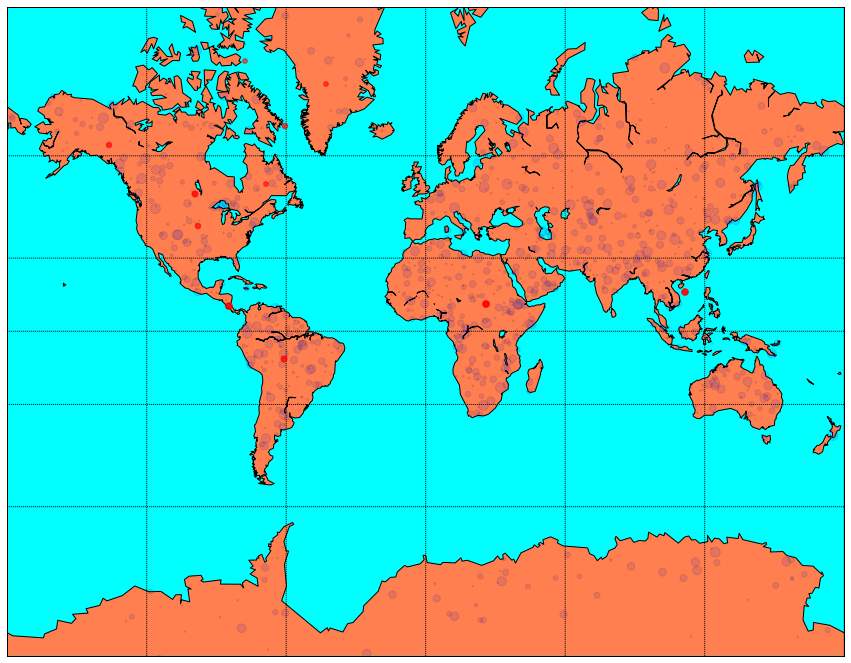

In [26]:
f = plt.figure(figsize=(15,15))
centroids = clust_model.cluster_centers_
centroids2 = centroids[0:2]
m = pt_map(samp.sample(1000))

c_trip = 1
solution = pd.DataFrame({'GiftId':[0], 'TripId':[0]})

solution = kmeans_divide(samp, m, solution, c_trip)

"""
for name, group in grouped:
    print('\rOn trip {} of {}'.format(name+1, len(grouped)), end='')
    #if name < 30: continue
    w = group.Weight.sum()
    if w > weight_limit - sleigh_weight:
        solution = kmeans_divide(group, m, solution, c_trip)
    else:
        path = anneal(group)
        solution = solution.append( pd.DataFrame({'GiftId': path.GiftId, 'TripId' : solution.TripId.max()+1}))
        
        #xx, yy = m(path['Longitude'].tolist(), path['Latitude'].tolist())
        #plt.plot(xx, yy, linewidth=1.5,color='r')
"""
solution = solution[solution.TripId != 0]
x1, y1 = m(centroids[:,0], centroids[:,1])
plt.scatter(x1, y1, marker='o', s=50, zorder=100)
plt.show()

In [21]:
print(WRW(solution.merge(samp, on='GiftId')))
print(bench_WRW)

0.0
144525525772.0


2     1593902842
10    1593230592
100   1581096640
1000  1606134779

In [ ]:
solution.to_csv('out.csv', columns=['GiftId', 'TripId'])